In [1]:
import os

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Resize, transforms, Compose
from torchvision.models import mobilenet_v3_small, MobileNet_V3_Small_Weights, vgg16, VGG16_Weights
import pandas as pd
from pandas import DataFrame
from PIL import Image
import matplotlib.pyplot as plt

torch.manual_seed(1234)

In [2]:
df = pd.read_csv('datasets/ret_annot.csv')

In [3]:
df = pd.read_csv('datasets/ret_annot.csv')
filenames = df['id_code']

def balance_data(df:DataFrame, n_classes:int=5, n_samples:int=200, save:bool=True, dir_path:str=None) -> DataFrame:
    """Balance the dataset with n_samples of each classes samples """
    data_per_labels = {}
    for label in range(n_classes):
        data = df[df['diagnosis'] == label]
        data_per_labels[label] = data[:n_samples]

    data_stats = {i: len(data) for i, data in data_per_labels.items() }
    balanced_data = pd.concat(data_per_labels.values(), ignore_index=True)
    
    if save:
        file_name = f'annot_balanced_{n_samples}.csv'
        if dir_path is None:
            dir_path = ''
        file_path = os.path.join(dir_path, file_name)
        
        balanced_data.to_csv(file_path, index=False)
    
    return balanced_data

data = balance_data(df)
labels = data['diagnosis']
print(len(data))

993


In [4]:
from collections import Counter
import numpy as np

counter = Counter(labels.to_list())
data_per_labels = np.array(list(counter.values()))
# plt.bar(range(len(data_per_labels)), data_per_labels)
print(counter)

Counter({0: 200, 1: 200, 2: 200, 4: 200, 3: 193})


In [5]:
class RetDataset(Dataset):
    """load retinopathy dataset"""
    def __init__(self, data_path:str, annot_path:str=None, transform=None) -> None:
        self.annots = pd.read_csv(annot_path)
        self.data_path = data_path
        self.transform = transform
    
    def __len__(self, ) -> int:
        return len(self.annots)
    
    def __getitem__(self, idx)->torch.Tensor:
        filename, label = self.annots.iloc[idx]
        file_path = os.path.join(self.data_path, filename + '.png')
        img = Image.open(file_path)
        
        if self.transform:
            img_tensor = self.transform(img)
        else:
            img_tensor = ToTensor()(img) 
            img_tensor = Resize((256, 256))(img_tensor)
        
        return img_tensor, torch.tensor(label)

In [6]:
from torch.nn import functional as F
import torch.nn as nn

class Net(nn.Module):
    """Custom network for retinopathy detection"""
    def __init__(self, in_c:int, out_c:int, nb_cl:int=5):
        super().__init__()
        self.features = nn.Sequential(nn.Conv2d(in_c, out_c, 3), 
        nn.ReLU(),
        nn.MaxPool2d(2, 2), 
        nn.Conv2d(out_c, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(2, 2), )
        
        self.classifier = nn.Sequential(nn.Linear(246016, 1000), nn.Linear(1000, nb_cl))

    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 246016)
        x = self.classifier(x)
        return x

In [7]:
model = Net(3, 64)

In [8]:
tmp = model.features[-1]

In [9]:
# configs
dataset_path = 'datasets/ret_dataset/'
annot_path = 'annot_balanced_200.csv'
n_classes = 5

In [10]:
# splitting the dataset
transform = Compose([ToTensor(), Resize((256, 256))])
dataset = RetDataset(dataset_path, annot_path, transforms)

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.2])

train_dataloader = DataLoader(train_dataset, batch_size=16 ,shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16)
# dataloader = DataLoader(dataset, batch_size=16 ,shuffle=True) 

In [11]:
# hyperparameters
lr = 0.01
epochs = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
def train(model, dataloader, criterion, optimizer, save=True, checkpt_path=None) -> None:
    """train model and save it if save is true"""
    model.train()
    model.to(device)
    checkpt = {}
    for epoch in range(epochs):
        acc = 0
        for x, y in dataloader:
            x.to(device)
            y.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y.flatten())
            loss.backward()
            acc += (y_pred.argmax(dim=1) == y.flatten()).sum()
            optimizer.zero_grad()
            optimizer.step()
        
        if epoch%100 == 0 and save:
            checkpt['model_st_dict'] = model.state_dict()
            checkpt['acc'] = acc
            checkpt['loss'] = loss
            if checkpt_path is None:
                checkpt_path = ''
            checkpt_file_name =  f'checkpoint_{epoch}.pth'
            checkpt_file_path = os.path.join(checkpt_path, checkpt_file_name)
            torch.save(checkpt, checkpt_file_path)
            
        print(f'{epoch} epochs: {loss.item()} acc = {acc/(len(dataloader)*16)}')

In [37]:
class GenRetSample():
    """ Generate randomly dataset sample: img, target"""
    def __init__(self, dataset, shuffle=True):
        self.dataset = dataset
        self.dataset_len = len(dataset)
        self.random_idxs = random.sample(range(self.dataset_len), self.dataset_len)
        self.index = 0
    
    def __iter__(self, ):
        return self
    
    def __next__(self):
        if len(self.dataset) > self.index:
            self.index += 1
            return dataset[self.random_idxs[self.index]]
        else :
            raise StopIteration()

In [38]:
dataset = RetDataset(dataset_path, annot_path, transform)
gen = GenRetSample(dataset)
img, lab = next(gen)

img_np = img.numpy()
img_np = img_np.swapaxes(0, 2)
print(img_np.shape)

(256, 256, 3)


In [90]:
# import os    
# os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
def display(dataset):
    gen = GenRetSample(dataset)
    img, lab = next(gen)

    img_np = img.numpy()
    img_np = img_np.swapaxes(0, 2)

    plt.imshow(img_np)
    plt.axis('off')
    plt.text(10, 10, str(lab.item()), color='white', fontsize=12,
             bbox=dict(facecolor='black', alpha=0.5))
    plt.show()

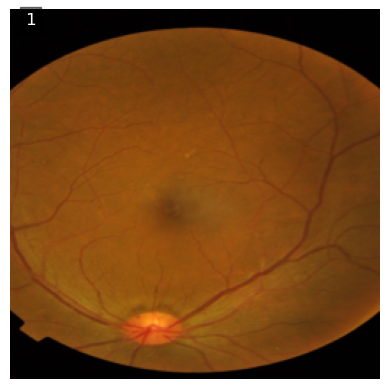

In [121]:
dataset = RetDataset(dataset_path, annot_path, transform)
display(dataset)

In [122]:
# load mobilenet v3
def get_mobilenet_v3(n_classes:int=5, weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1) -> torch.nn.Module:
    """Return mobilenet_v3 model with frozen features layers"""
    model_small = mobilenet_v3_small(weights=weights)
    model_small.classifier[-1] = nn.Linear(in_features=1024, out_features=5)

    # deactivate gradient computation the features layers
    for param in model_small.features.parameters():
        param.requires_grad = False
    
    return model_small

In [31]:
def get_vgg16(n_classes:int=5, weights=VGG16_Weights.IMAGENET1K_V1) -> torch.nn.Module:
    """Return VGG16 model with frozen features layers"""
    vgg_model = vgg16(weights=weights)
    vgg_model.classifier[-1] = torch.nn.Linear(in_features=4096, out_features=n_classes)

    for param in vgg_model.features.parameters():
        param.requires_grad = False
    
    return vgg_model

In [72]:
# Data preparation for mobilenet
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

dataset_pretrained = RetDataset(dataset_path, annot_path)
dataloader_pretrained = DataLoader(dataset_pretrained, batch_size=16, shuffle=True)

In [73]:
model = get_mobilenet_v3()
x, _ = dataset_pretrained[0]
x = x.unsqueeze(dim=0)
model(x), _

(tensor([[ 0.0020, -0.1747,  0.1279,  0.0101, -0.1136]],
        grad_fn=<AddmmBackward0>),
 tensor(0))

In [76]:
# Training
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
train(model, dataloader_pretrained, criterion, optimizer)

In [110]:
@torch.no_grad
def test(model, dataloader_test):
    model.eval()
    acc = 0
    data_size = len(test_dataloader.dataset)
    for x, y in dataloader_test:
        y_pred = model(x) 
        acc += (y_pred.argmax(dim=1) == y).sum()
    print(f"test accuracy: {acc/data_size}")

In [56]:
dataset = RetDataset(dataset_path, annot_path, transform)
gen = GenRetSample(dataset)
img, lab = next(gen)

model = Net(3, 64)
x_1 = img.unsqueeze(dim=0)
with torch.no_grad():
    y_1 = model(x_1)
    print(y_1.argmax(dim=1), lab)

tensor([1]) tensor(0)


In [ ]:
# Save a checkpoint during training
checkpoint = {
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': loss,
}

torch.save(checkpoint, 'checkpoint.pth')

# Load a checkpoint
checkpoint = torch.load('checkpoint.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [116]:
def load_model(checkpoint_path=None, arch='vgg'):
    model_checkpt = torch.load(checkpoint_path)
    return model_checkpt